# Introduction

We will have a look at the global mean temperature anomalies from 1850 to today, and explore some visualisations of climate change.

1. First, we can have a look at the earth's average land atmospheric temperature from 1850 to 2019.
2. The understanding is clear that atmospheric CO2 levels has the strongest warming effect on the climate. So we will look into climate temperature movements along with atmospheric CO2.
3. Is it possible to suggest that the climate change is due to the earth's cyclical solar movements?
4. How do countries fare in their emissions?

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
import Wrangler as Wr
import HawkinsStripes as Hs
import Countrypack as Cp

# Function to expand confidence intervals for temperature data
def makeConfidenceInt(data,period):
    upper = period + 'Up'
    lower = period + 'Lo'
    anomaly= period + 'Anomaly'
    uncertainty = period + 'Unc'
    data[upper] = data[anomaly] + data[uncertainty]
    data[lower] = data[anomaly] - data[uncertainty]
    


# Datasets

### 1. Berkeley Earth Land + Ocean Temperature data

Berkeley Earth have provided a very detailed summary dataset of average changes in the Earth's global average surface temperature. The estimation dataset combines the Berkeley Earth land-surface temperature (BEST) field with a reinterpolated version of the Met Office Hadley Centre's sea surface temperature (HadSST) data set.

This data set reports two versions of the summarised average temperatures, which differ in how they treat locations with sea ice. For our report, we will use the version that extrapolates temperature anomalies from land-surface air temperatures in areas where sea ice is present. The other version uses sea-surface water temperature anomalies, which were usually collected from open water areas on the periphery of the sea ice. 

Following the advice of Berkeley Earth, we use air temperatures above sea ice because it provides a more natural means of describing temperature changes in the Earth's surface temperature. While most sea-surface temperatures are close to the near-surface air temperatures, they can differ substantially in open water areas surrounding sea ice. The average air temperature of this data shows larger changes than water sea-surface water temperatures in recent periods. This is in part because water temperature changes are limited by the freezing point of water.

In a typical month, sea ice covers between 3.5% and 5.5% of the Earth's Surface. 

The temperatures in this dataset are in Celcius and are reported as anomalies relative to the Jan 1951 - Dec 1980 average. Uncertainties in the dataset represent the 95% confidence interval for statistical and spacial undersampling effects as well as ocean biases. 

The estimated Jan 1951 - Dec 1980 global mean temperature (C) using air temperature above sea ice is: 

    14.178 +/- 0.048.
    
This dataset reports the estimated global surface temperature anomalies for each month, and its uncertainty. Further, it also reports corresponding values for year, five-year, ten-year, and twenty-year moving averages CENTERED about that month. For example, the annaual average from January to December 1950 is reported at June 1950.

For further details about the Berkeley Earth Land + Ocean Temperature data:
http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt

A brief summary of the strengths and weaknesses of the Berkeley Earth data:
https://climatedataguide.ucar.edu/climate-data/global-surface-temperatures-best-berkeley-earth-surface-temperatures

Further information about Berkeley Earth's data methodology can be found here:
http://berkeleyearth.org/about-data-set/

In [3]:
# Load Global Temperature data
filePath = Wr.makeDirFile('Global_Temperature')
tempdata = pd.read_csv(filePath)

# Convert date to datetime
tempdata.Date = pd.to_datetime(tempdata.Date, format='%Y-%m-%d', errors='coerce')

# Create date index
tempdata = tempdata.set_index('Date')

# Convert string month to categorical datatype
months_order = ['January', 'February', 'March', 'April','May','June',
                'July','August','September','October','November','December']
tempdata.strMonth = pd.Categorical(tempdata.strMonth, 
                     categories=months_order, ordered=True)

The average temperature anomalies are reported as relative a standardised mean of 0. To derive actual temperatures, use the estimated Jan 1951 - Dec 1980 mean temperature of 14.178.

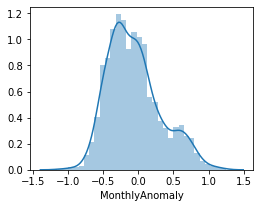

In [4]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.distplot(tempdata.MonthlyAnomaly);

Further, the year, five-year, ten-year and twenty-year moving averages results in trimming the leading and trailing observations up to the number of observations used to calculate an average. For example, the annual average anomalies trims data from the first 5 months and final 6 months in the data. 

In [5]:
print(tempdata.isnull().sum())
# tempdata

Year                   0
Month                  0
MonthlyAnomaly         0
MonthlyUnc             0
AnnualAnomaly         11
AnnualUnc             11
FiveYearAnomaly       59
FiveYearUnc           59
TenYearAnomaly       119
TenYearUnc           119
TwentyYearAnomaly    239
TwentyYearUnc        239
centerMean             0
centerUnc              0
strMonth               0
Country                0
dtype: int64


As the Berkeley Earth data has already filtered duplicates across their data archives, there is no need to further clean duplicate data.

In [6]:
print('Number of duplicates:',tempdata.duplicated().sum())

Number of duplicates: 0


### 1.2 Berkeley Earth Surface Temperature by Country

We also include country data

In [7]:
# Load Country Temperature data
filePath = Wr.makeDirFile('Temp_countries')
cTempdata = pd.read_csv(filePath)

# Convert date to datetime
cTempdata.Date = pd.to_datetime(cTempdata.Date, format='%Y-%m-%d', errors='coerce')

# Create a Month name column
cTempdata['strMonth'] = cTempdata.Date.dt.month_name()

# Create non-index Date
cTempdata['nonIndexDate'] = cTempdata.Date

# set date index
cTempdata = cTempdata.set_index('Date')

# Convert string month to categorical datatype
months_order = ['January', 'February', 'March', 'April','May','June',
                'July','August','September','October','November','December']
cTempdata.strMonth = pd.Categorical(cTempdata.strMonth, 
                     categories=months_order, ordered=True)

### 2. NOAA Mauna Loa Observatory monthly mean CO2

This data shows mean monthly atmospheric carbon dioxide measured at Mauna Loa Observatory, Hawaii. The time period for which the measurements are available are from 1958 to the present.

The data reports the monthly average CO2 mole fraction determined from daily averages. The mole fraction of CO2, expressed as parts per million (ppm), is the number of molecules of CO2 in every one million molecules of dried air (water vapour removed).

Some months in the average CO2 column is missing data. So in addition to the monthly average CO2 column, the data provides an 'interpolated' column which includes average values from the 'average' column, and interpolated values where data are missing.

The interpolated values were computed in two steps: 

    First, the average seasonal cycle for each month was computed in a 7-year window around each monthly value. In this way, the seasonal cycle is allowed to change slowly over time.

    Second, the 'trend' value for each month was determined by removing the seasonal cycle; this result is shown in the 'trend' column. The trend values are linearly interpolated for missing months.

The 'interpolated' monthly mean is therefore the sum of the average seasonal cycle value and the trend value for the missing month.

For more information about the Mauna Loa CO2 data: https://www.esrl.noaa.gov/gmd/ccgg/trends/mlo.html

In [8]:
# Load Global Temperature data
filePath = Wr.makeDirFile('co2_mm_mlo.csv')
co2Data = pd.read_csv(filePath)

# Convert date to datetime
co2Data.Date = pd.to_datetime(co2Data.Date, format='%Y-%m-%d', errors='coerce')

# Create date index
co2Data = co2Data.set_index('Date')

The 'days' column indicates the number of daily average CO2 data computed in the monthly average. Where days equals -1, this means there were no daily averages in computing the month's average.

In [9]:
co2Data

,Year,Month,average,interpolated,trend,days
Date,,,,,,
1958-03-01,1958,3,315.71,315.71,314.62,-1
1958-04-01,1958,4,317.45,317.45,315.29,-1
1958-05-01,1958,5,317.50,317.50,314.71,-1
1958-06-01,1958,6,NaN,317.10,314.85,-1
1958-07-01,1958,7,315.86,315.86,314.98,-1
...,...,...,...,...,...,...
2019-09-01,2019,9,408.54,408.54,412.15,29
2019-10-01,2019,10,408.53,408.53,411.95,30
2019-11-01,2019,11,410.27,410.27,412.27,25


In [10]:
# Note just 7 instances of missing monthly average data
co2Data.isnull().sum()

Year            0
Month           0
average         7
interpolated    0
trend           0
days            0
dtype: int64

### 3. Historical Carbon Dioxide Record from the Vostok Ice Core

Ice cores provide a unique historical record of past atmospheric gas compositions. Small air bubbles are encased in antarctic ice cores over many hundreds of thousands of years, and so enable a direct record of past changes in the atmospheric gas composition. 

For our dataset, we will be using the Vostok Ice core data. The Vostok ice core was drilled in January 1998 at the Russian Vostok station in East Antarctica, yielding the deepest ice core ever recovered. Preliminary records indicate that the Vostok ice core record extends through four climate cycles, with ice slightly older than 400,000 years.

Note that since air bubbles do not close at the surface of the ice sheet, but only near the firn-ice transition (~90m below the surface at Vostok), the air extracted from the ice is youngerthan the surrounding ice. As such, the ice core data provides separate columns for the age of the ice and mean age of the air in years before present (yr BP).

The CO2 concentration estimates for each age are measured in parts per million by volume (ppmv). The CO2 gas concentration estimates from the ice core are similar to the atmospheric CO2 measured in ppm from the data above. 

More information about the Vostok ice corea CO2 data may be found at: https://cdiac.ess-dive.lbl.gov/trends/co2/vostok.html


In [11]:
# Load Vostok ice core CO2 data
filePath = Wr.makeDirFile('vostok_co2')
vosCO2Data = pd.read_csv(filePath)

The data has already been provided in a clean format, with no instances of missing data.

In [12]:
print('Missing data report:')
print(vosCO2Data.isnull().sum())

Missing data report:
Depth_m                 0
Age_of_ice_yrBP         0
Mean_age_of_air_yrBP    0
CO2_conc_ppmv           0
dtype: int64


There are 5 duplicated values in the Age_of_ice_column. However, since the ages are estimated values, these duplicated values generally occur at instances where the depths are 0.01 meters apart from each other. Further, since we are looking at the CO2 concentration in the ice cores, the age variable we are interested in is the mean age of the air.

Within the mean age of air, there is just one duplicated value. This, incidentally, also is a duplicated depth of 3289.45. These observations differ in their CO2 concentrations however. It may be possible that the difference in depth between the two observations was negligibly small, thus appearing as a duplicated depth. 

As we may index the age of the air value for some following analysis, we will keep the first of the duplicate value for simplicity. The difference in CO2 concentrations between the two duplicates appears negligibly small with respect to the range at which CO2 concentrations vary in the ice core.


In [13]:
# vosCO2Data[vosCO2Data.Age_of_ice_yrBP.duplicated()]
vosCO2Data[vosCO2Data.Mean_age_of_air_yrBP.duplicated()]

,Depth_m,Age_of_ice_yrBP,Mean_age_of_air_yrBP,CO2_conc_ppmv
358,3289.45,411202,409022,283.7


In [14]:
vosCO2Data[vosCO2Data.Depth_m.duplicated()]

,Depth_m,Age_of_ice_yrBP,Mean_age_of_air_yrBP,CO2_conc_ppmv
358,3289.45,411202,409022,283.7


In [15]:
vosCO2Data[vosCO2Data.Mean_age_of_air_yrBP.isin([409022])]

,Depth_m,Age_of_ice_yrBP,Mean_age_of_air_yrBP,CO2_conc_ppmv
357,3289.45,411202,409022,281.2
358,3289.45,411202,409022,283.7


In [16]:
vosCO2Data = vosCO2Data.drop_duplicates(subset=['Mean_age_of_air_yrBP']).reset_index().drop(columns=['index'])

The oldest record of gas in the ice core is estimated at around 417,160 years BP, with the most recent record at 2,342 year BP.

This differs from the age of the ice, as mentioned above. So the oldest age of ice is estiamted at 419,328 year BP, with the youngest ice at 5,679 years BP.

In [17]:
vosCO2Data.describe()

,Depth_m,Age_of_ice_yrBP,Mean_age_of_air_yrBP,CO2_conc_ppmv
count,362.000000,362.000000,362.000000,362.000000
mean,2389.611215,215853.472376,211781.397790,232.044199
std,776.107202,98693.445468,99012.526782,28.395867
min,149.100000,5679.000000,2342.000000,182.200000
25%,1948.875000,137014.500000,132947.000000,206.475000
50%,2648.005000,220467.500000,217422.500000,231.400000
75%,2996.752500,292671.500000,288330.500000,252.775000
max,3304.400000,419328.000000,417160.000000,298.700000


### 4. Historical Isotopic Temperature Record from the Vostok Ice Core

It is also possible to determine historical climate temperature records from the Vostok ice core data.

This is possible because, while water molecules in the ice are comprised of two hydrogen atoms and one oxygen atom (H$_{2}$O), there are several isotopes of oxygen and hydrogen, the presence of which, is temperature dependent. Scientists can measure these as a proxy for temperature. Isotopes are chemically identical atoms with the same number of protons, but differing numbers of neutrons, and therefore mass. Scientists are most interested in the heavier oxygen-18 ($^{18}$O) and deterium ($^{2}$H also known as D) isotopes when estimating historical temperatures.

Simply put, there are two processes which affect the isotopic fractions of the heavier oxygen-18 and deuterium.

    First it takes more energy to evaporate the water molecules containing a heavy isotope from the surface of the ocean.
    Second, as the moist air is transported polewards and cools, the water molecules containing heavier isotopes are preferentially lost in precipitation. 
    
Both of these processes, known as fractionation, are temperature dependent. Therefore, there is generally less $^{18}$O and $^{2}$H during cold periods than there is warm.

This site provides a more detailed explanation of this process: https://www.scientificamerican.com/article/how-are-past-temperatures/

For more details of the data itself, and the methodology: https://cdiac.ess-dive.lbl.gov/trends/temp/vostok/jouz_tem.htm

The columns we are interested in for our analysis are primarily the age of the ice (years BP) and the Temperature variation which is measured in degress Celcius (C). 

The temperature variance is around the freezing point of water, so note that this is not a record of the global atmospheric temperatures.

In [44]:
# Load Vostok ice core temp data
filePath = Wr.makeDirFile('vostok_temp')
vosTempData = pd.read_csv(filePath)

We note there are no missing values or duplicated values in the data

In [19]:
print('Duplicated age of ice:',vosTempData.Age_of_ice_yrBP.duplicated().sum())
print('Duplicated depth m:',vosTempData.Depth_m.duplicated().sum())
print('Missing values:\n',vosTempData.isnull().sum())

Duplicated age of ice: 0
Duplicated depth m: 0
Missing values:
 Depth_m             0
Age_of_ice_yrBP     0
Deuterium_deltaD    0
Temp_var_C          0
dtype: int64


### 5. Emissions data

In [101]:
# Load emissions data
filePath = Wr.makeDirFile('emission data')
emData = pd.read_csv(filePath)

In [102]:
# Data needs to be transposed to be used as a time series
emData = emData.rename(columns={'Country':'Year'})
emData = emData.set_index('Year').T

Note there are two grouped categories: EU-28 and World.

# Preprocessing

### All datasets:
In summary, we have four datasets as part of our analysis in this report.
1. tempdata
2. co2Data
3. vosCO2Data
4. vosTempData

Before we dive into the analysis, we need to perform some additional processing to prepare the data.

1. Generate separate upper and lower confidence bounds for the temperature data

In [20]:
for period in ['Monthly','Annual','TenYear','TwentyYear']:
    makeConfidenceInt(tempdata,period)

2. Merge the atmospheric CO$_{2}$ data with main temperature variance data.

In [21]:
# Join data, using CO2 as "other"
tempdata = tempdata.join(co2Data, rsuffix='_other').drop(columns=['Year_other', 'Month_other'])

# Rename CO2 data with co2 prefix
tempdata.rename(columns={'average':'co2Avg', 'interpolated':'co2Interpolated', 'trend':'co2Trend','days':'co2Days'}, inplace=True)

3. Create pivot tables for each of the time period resolutions in the temperature data. These will be used to generate heatmaps of the temperatures over time.

In [22]:
monthData = tempdata.pivot('strMonth','Year','MonthlyAnomaly')
annualData = tempdata.pivot('strMonth','Year','AnnualAnomaly').dropna(axis=1)
fiveYearData = tempdata.pivot('strMonth','Year','FiveYearAnomaly').dropna(axis=1)
tenYearData = tempdata.pivot('strMonth','Year','TenYearAnomaly').dropna(axis=1)

4. Join Vostok icecore CO$_{2}$ and temperature data.

In [23]:
# Create new dataframes after removing columns we are not interested in
joinedVos = vosCO2Data.drop(columns=['Depth_m','Age_of_ice_yrBP'])
vosTempjoin = vosTempData.drop(columns=['Depth_m','Deuterium_deltaD'])

# Rename the time period columns, this will create a consisten column for the dataframes to join by
joinedVos = joinedVos.rename(columns={'Mean_age_of_air_yrBP':'yearsBP'})
vosTempjoin = vosTempjoin.rename(columns={'Age_of_ice_yrBP':'yearsBP'})

# Merge the dataframes
joinedVos = pd.merge(joinedVos,vosTempjoin,on=['yearsBP'],how='outer')
joinedVos = joinedVos.sort_values('yearsBP').set_index('yearsBP')

# Since the years are not always exactly the same, lineraly interpolate the data to fill the gaps.
joinedVos['CO2Inter'] = joinedVos.CO2_conc_ppmv.interpolate()
joinedVos['TempInter'] = joinedVos.Temp_var_C.interpolate()

5. Add present day CO2 levels to historical CO2 data for later visualisation. 

We will add the most recent 2020 CO2 value with mean air age of 0, and the oldest atmospheric CO2 measurement (made in 1958) with mean air age equal to the present year minus 1958.

In [24]:
# Create a new dataframe holding the latest and oldest Mauna Loa CO2 observations
lCO2 = co2Data[-1:]['average'][0]
oCO2 = co2Data[0:1]['average'][0]
oldestAge = co2Data[-1:]['Year'][0] - co2Data[0:1]['Year'][0]
presentCO2 = pd.DataFrame([[0,lCO2], [oldestAge,oCO2]], columns=['Mean_age_of_air_yrBP','CO2Presentppm'])

# Create a complete CO2 data frame appending the latest CO2 readings to the vostok data
fullCO2Data = vosCO2Data.append(presentCO2,sort=True).drop(columns=['Age_of_ice_yrBP','Depth_m']).sort_values('Mean_age_of_air_yrBP').set_index('Mean_age_of_air_yrBP')

# Include an overlap with the Vostok data
fullCO2Data.loc[fullCO2Data.index.isin([2342]),'CO2Presentppm'] = 284.7

# Analysis

In [25]:
print(tempdata.loc[tempdata.MonthlyAnomaly.isin([tempdata.MonthlyAnomaly.max()])][['Year','Month']])

            Year  Month
Date                   
2016-02-01  2016      2


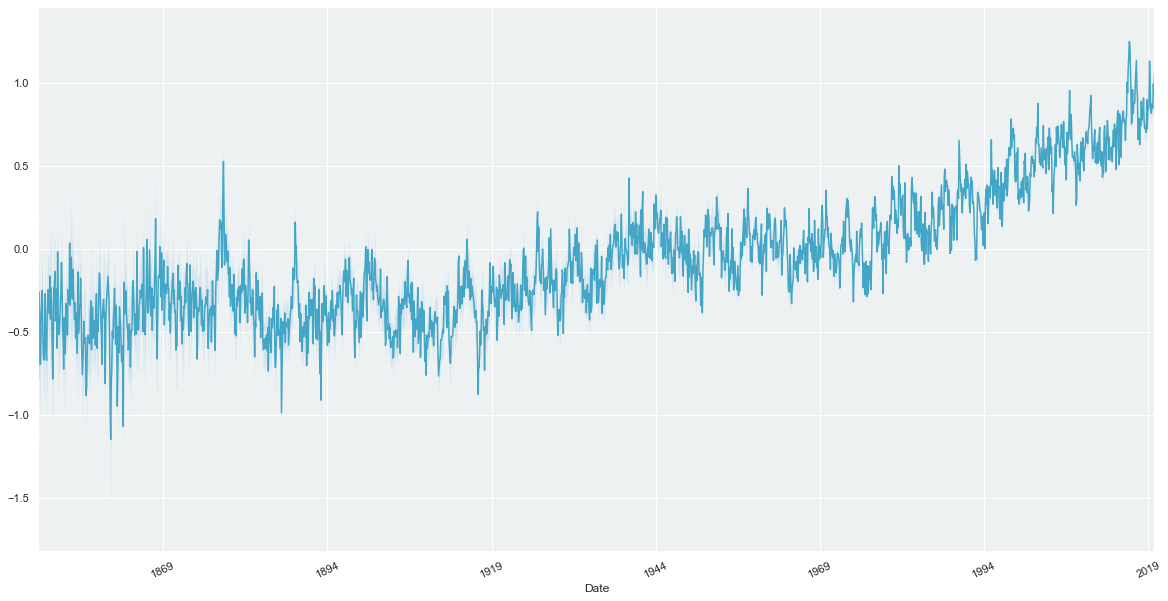

In [26]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(20, 10))
tempdata.MonthlyUp.plot(kind='line',alpha=0)
tempdata.MonthlyLo.plot(kind='line',alpha=0)
tempdata.MonthlyAnomaly.plot(kind='line',color='#43A6C6')

d = tempdata.index.values
plt.fill_between(d, tempdata.MonthlyUp, 
                 tempdata.MonthlyLo, 
                 where = tempdata.MonthlyUp>=tempdata.MonthlyLo,
                 facecolor = '#6baed6', 
                 alpha=0.2)
plt.xticks(rotation=25)
ax.set_facecolor('#EDF1F2')
plt.show()

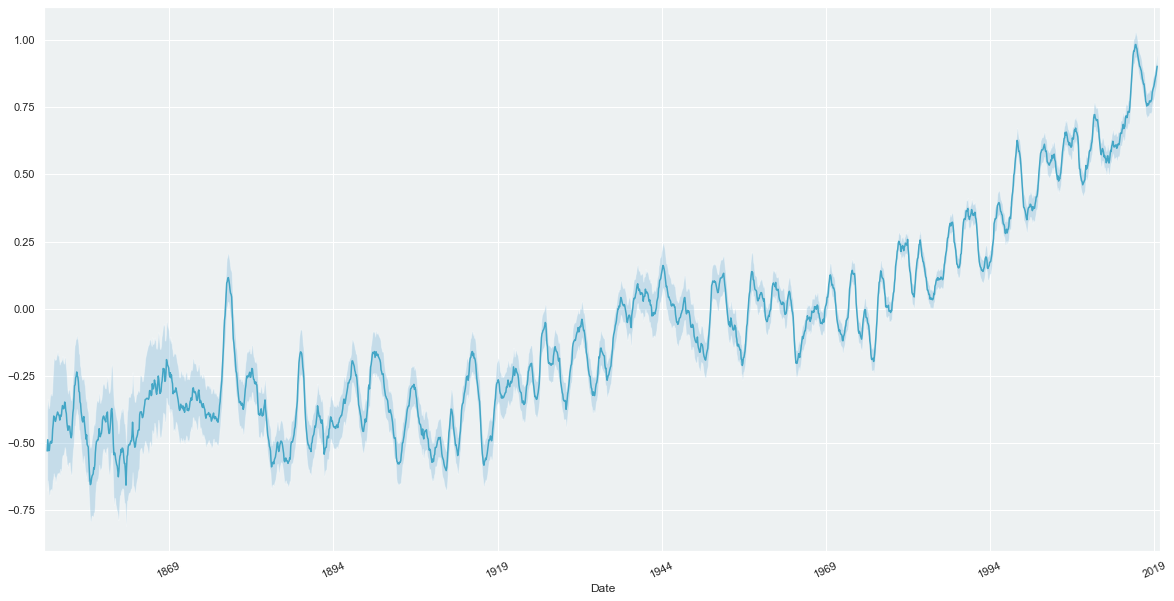

In [27]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(20, 10))
tempdata.AnnualUp.plot(kind='line',alpha=0)
tempdata.AnnualLo.plot(kind='line',alpha=0)
tempdata.AnnualAnomaly.plot(kind='line',color='#43A6C6')

d = tempdata.index.values
plt.fill_between(d, tempdata.AnnualUp, 
                 tempdata.AnnualLo, 
                 where = tempdata.AnnualUp>=tempdata.AnnualLo,
                 facecolor = '#6baed6', 
                 alpha=0.3)
plt.xticks(rotation=25)
ax.set_facecolor('#EDF1F2')
plt.show()

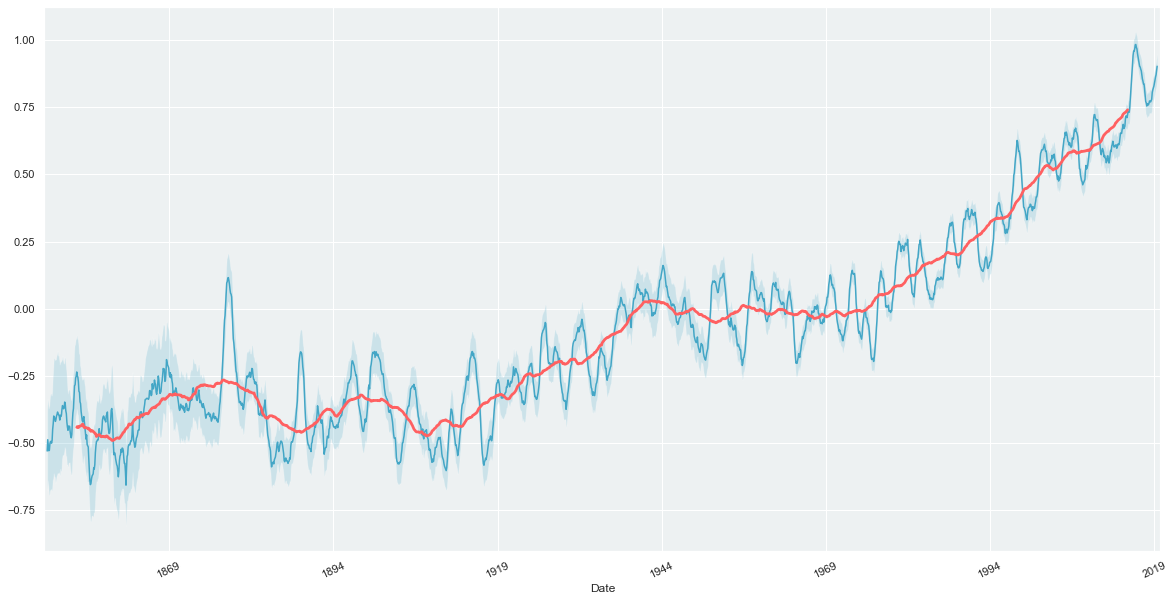

In [28]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(20, 10))
tempdata.AnnualUp.plot(kind='line',alpha=0)
tempdata.AnnualLo.plot(kind='line',alpha=0)
tempdata.AnnualAnomaly.plot(kind='line',color='#43A6C6')
tempdata.TenYearAnomaly.plot(kind='line',color='#FF6061',linewidth=2.75)
d = tempdata.index.values
plt.fill_between(d, tempdata.AnnualUp, 
                 tempdata.AnnualLo, 
                 where = tempdata.AnnualUp>=tempdata.AnnualLo,
                 facecolor = '#43A6C6', 
                 alpha=0.2)
plt.xticks(rotation=25)
ax.set_facecolor('#EDF1F2')
plt.show()

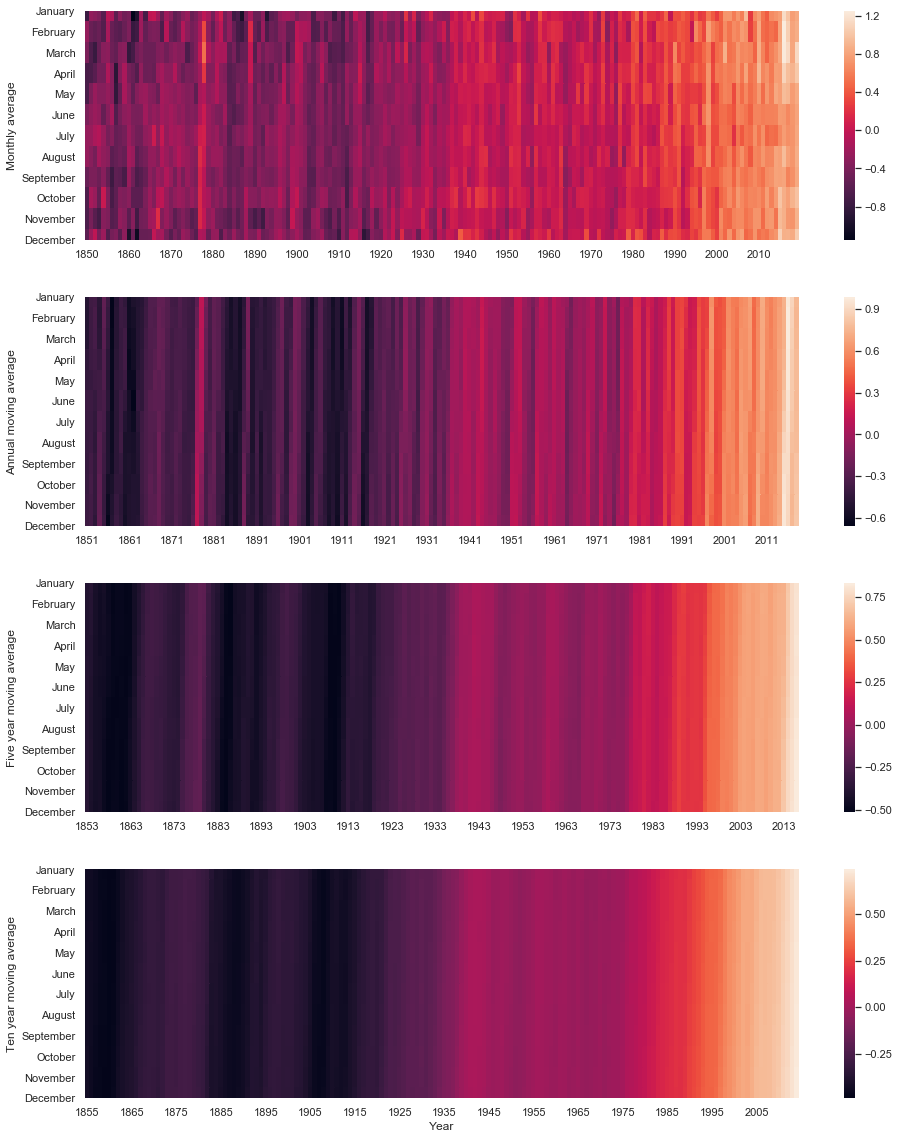

In [29]:
f, axes = plt.subplots(4, 1, figsize=(16, 20))

heat1 = sns.heatmap(monthData, xticklabels=10, ax=axes[0])
heat1.set_ylabel('Monthly average')
heat1.set_xlabel('')

heat2 = sns.heatmap(annualData, xticklabels=10, ax=axes[1])
heat2.set_ylabel('Annual moving average')
heat2.set_xlabel('')

heat3 = sns.heatmap(fiveYearData, xticklabels=10, ax=axes[2])
heat3.set_ylabel('Five year moving average')
heat3.set_xlabel('')

heat4 = sns.heatmap(tenYearData, xticklabels=10, ax=axes[3])
heat4.set_ylabel('Ten year moving average')


plt.subplots_adjust(hspace = 0.25)


Text(120.453125, 0.5, '')

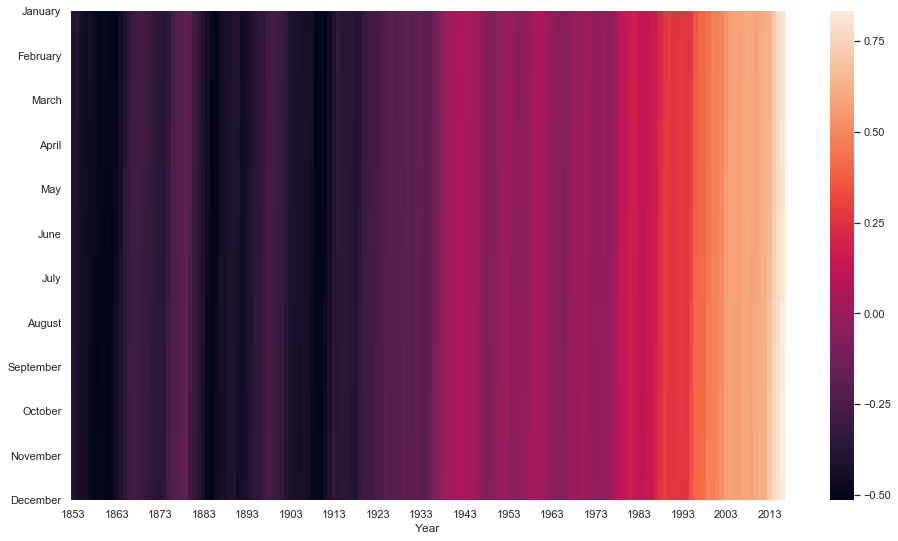

In [30]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(fiveYearData, xticklabels=10)
ax.set_ylabel('')

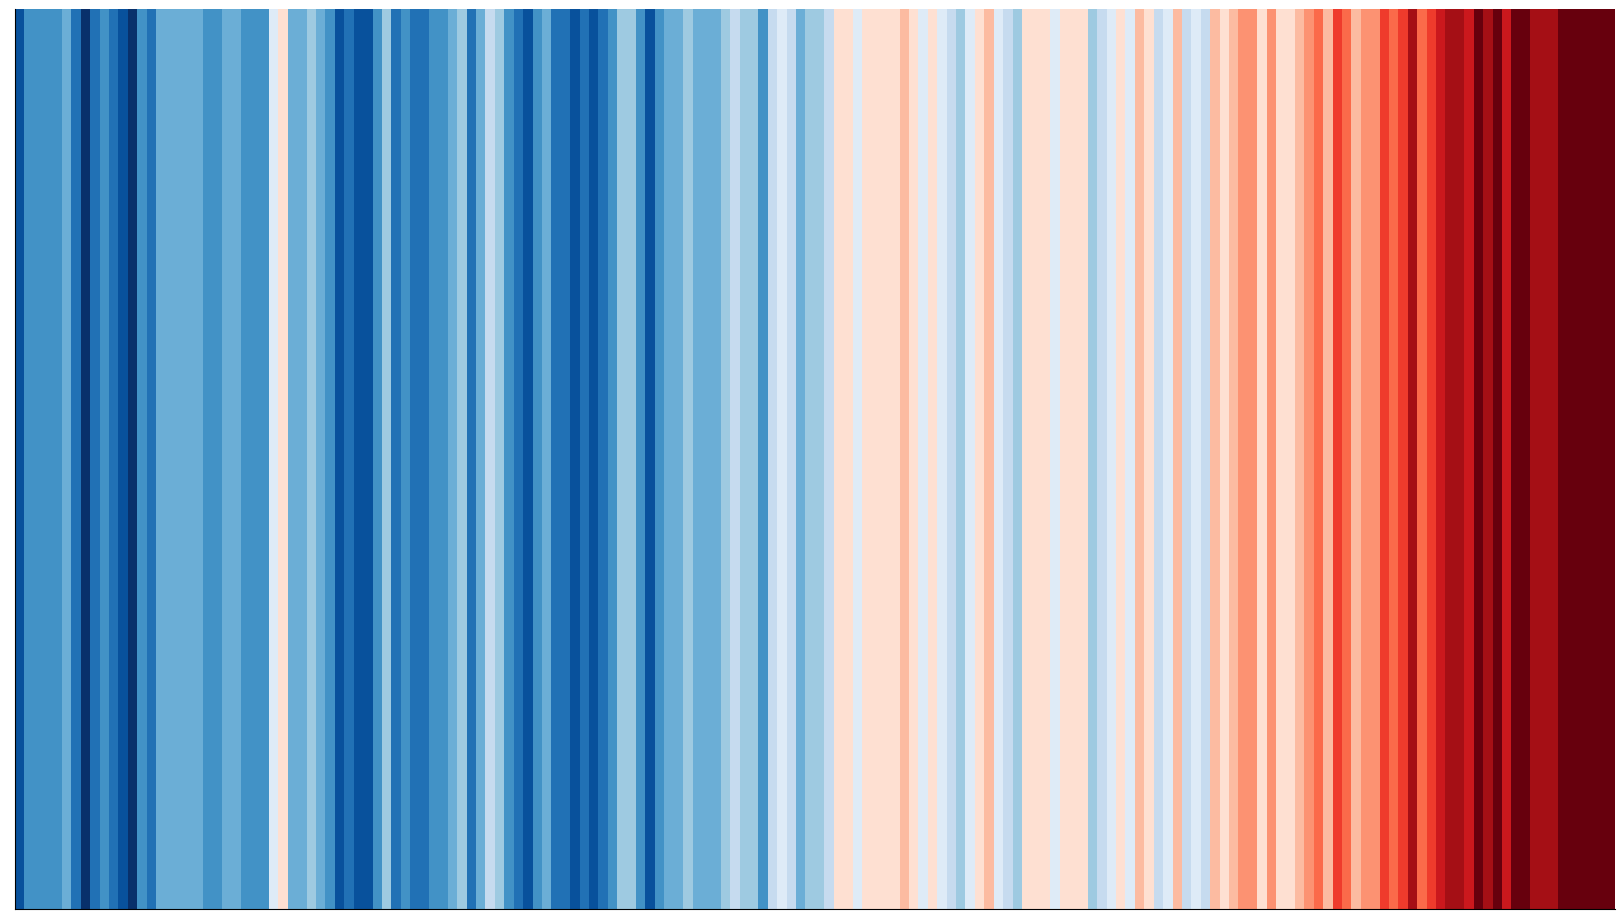

In [31]:
sns.reset_defaults()
Hs.makestripes(tempdata,'Global',xtrigger=False)

## CO2

In [32]:
co2Tempdata = tempdata.dropna(subset=['co2Trend'])

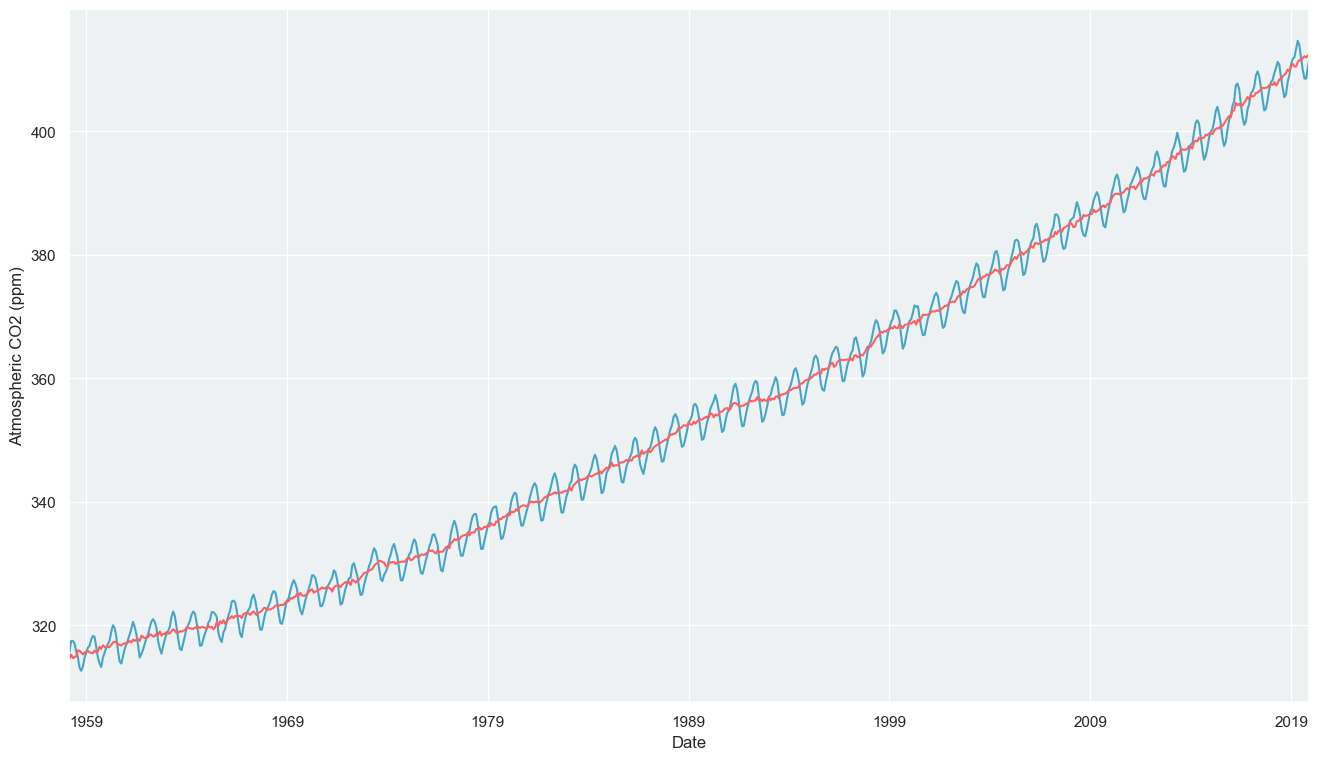

In [33]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
co2Tempdata.co2Interpolated.plot(kind='line',color='#43A6C6')
co2Tempdata.co2Trend.plot(kind='line',color='#FF6061')
ax.set_ylabel('Atmospheric CO2 (ppm)')
ax.set_facecolor('#EDF1F2')
plt.show()

In [34]:
co2Tempdata['co2Diff'] = co2Tempdata['co2Interpolated'] - co2Tempdata['co2Trend']
gb = co2Tempdata.groupby('strMonth')
gb[['co2Diff']].mean()

/Users/caruychen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,co2Diff
strMonth,
January,0.066885
February,0.691803
March,1.453871
April,2.562097
May,3.042258
June,2.296129
July,0.691452
August,-1.461290
September,-3.183226


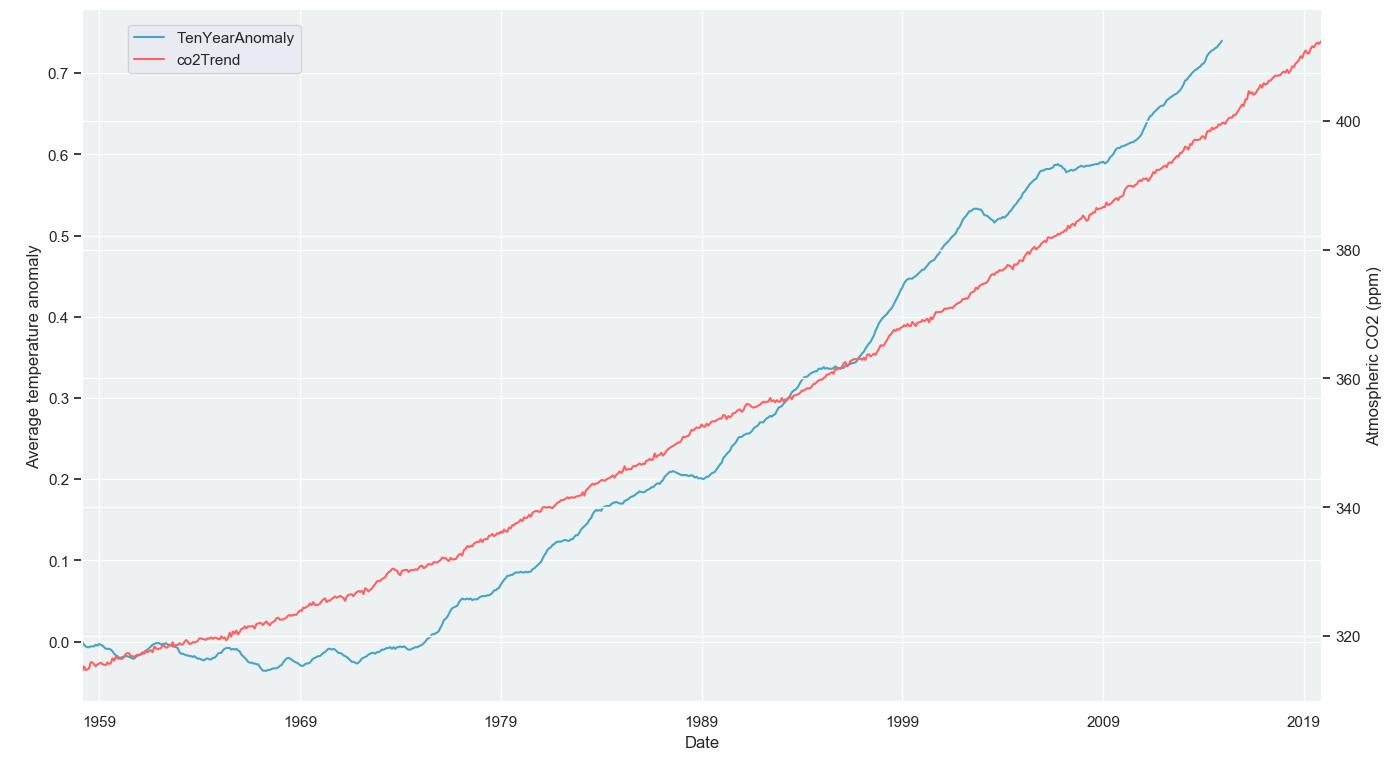

In [35]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))


ax1 = co2Tempdata.TenYearAnomaly.plot(kind='line',color='#43A6C6')
ax1.set_ylabel('Average temperature anomaly')
ax2 = ax.twinx()

co2Tempdata.co2Trend.plot(kind='line',color='#FF6061',ax=ax2)
ax2.set_ylabel('Atmospheric CO2 (ppm)')
ax.set_facecolor('#EDF1F2')
ax.figure.legend(loc='upper left', bbox_to_anchor=(0.075, 0.825))

plt.show()

# Historical climate records

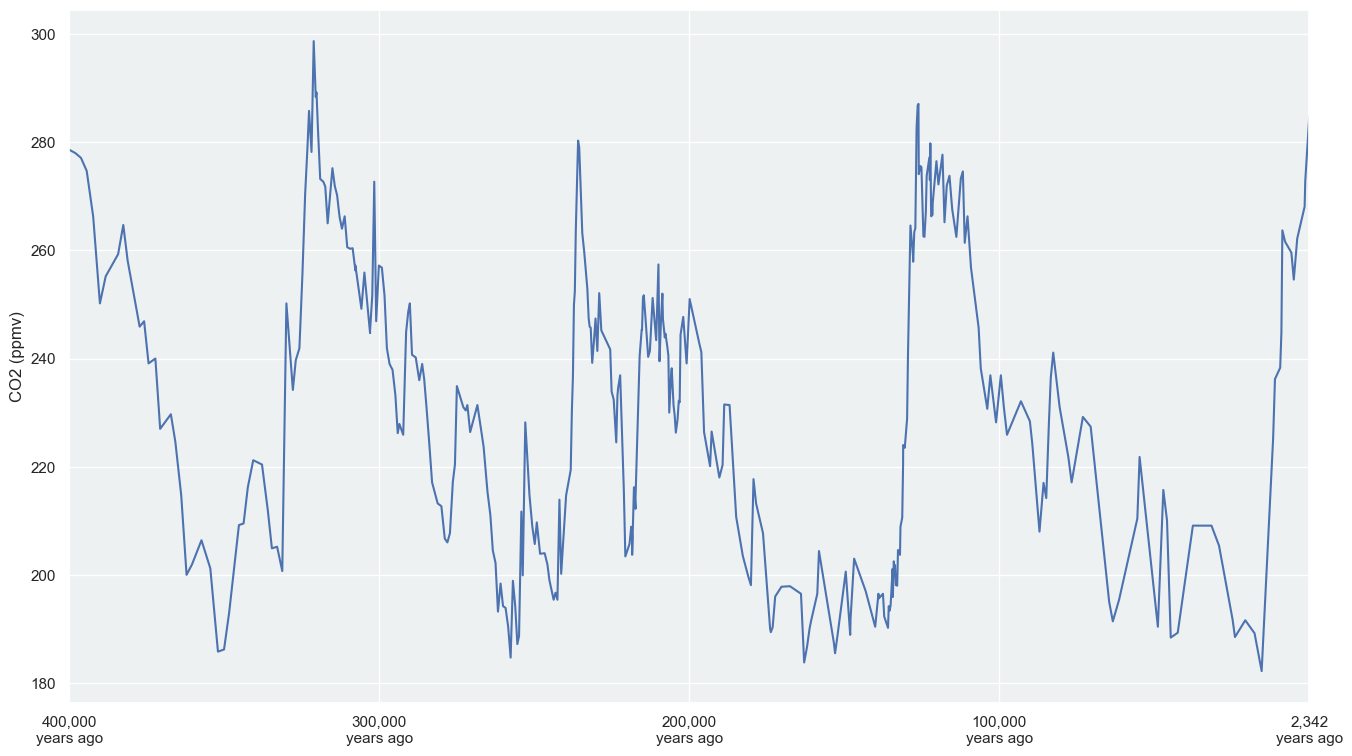

In [36]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_xlim(400000,2342)
plt.plot(vosCO2Data.Mean_age_of_air_yrBP,vosCO2Data.CO2_conc_ppmv)
plt.xticks(np.arange(2342,500000,step=100000),('2,342\nyears ago','100,000\nyears ago','200,000\nyears ago',
                                            '300,000\nyears ago','400,000\nyears ago'))
plt.ylabel('CO2 (ppmv)')
ax.set_facecolor('#EDF1F2')

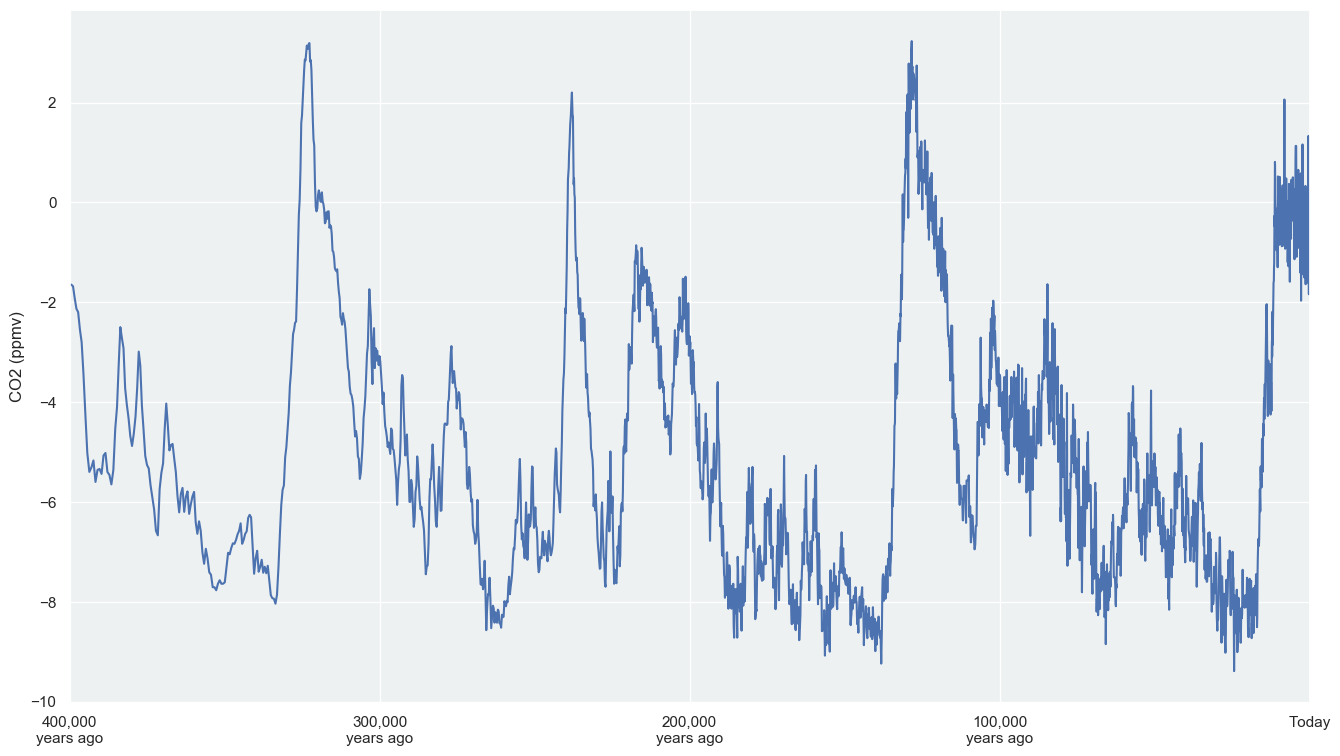

In [37]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))


ax.set_xlim(400000,0)
plt.plot(vosTempData.Age_of_ice_yrBP,vosTempData.Temp_var_C)
plt.xticks(np.arange(0,500000,step=100000),('Today','100,000\nyears ago','200,000\nyears ago',
                                            '300,000\nyears ago','400,000\nyears ago'))
plt.ylabel('CO2 (ppmv)')
ax.set_facecolor('#EDF1F2')

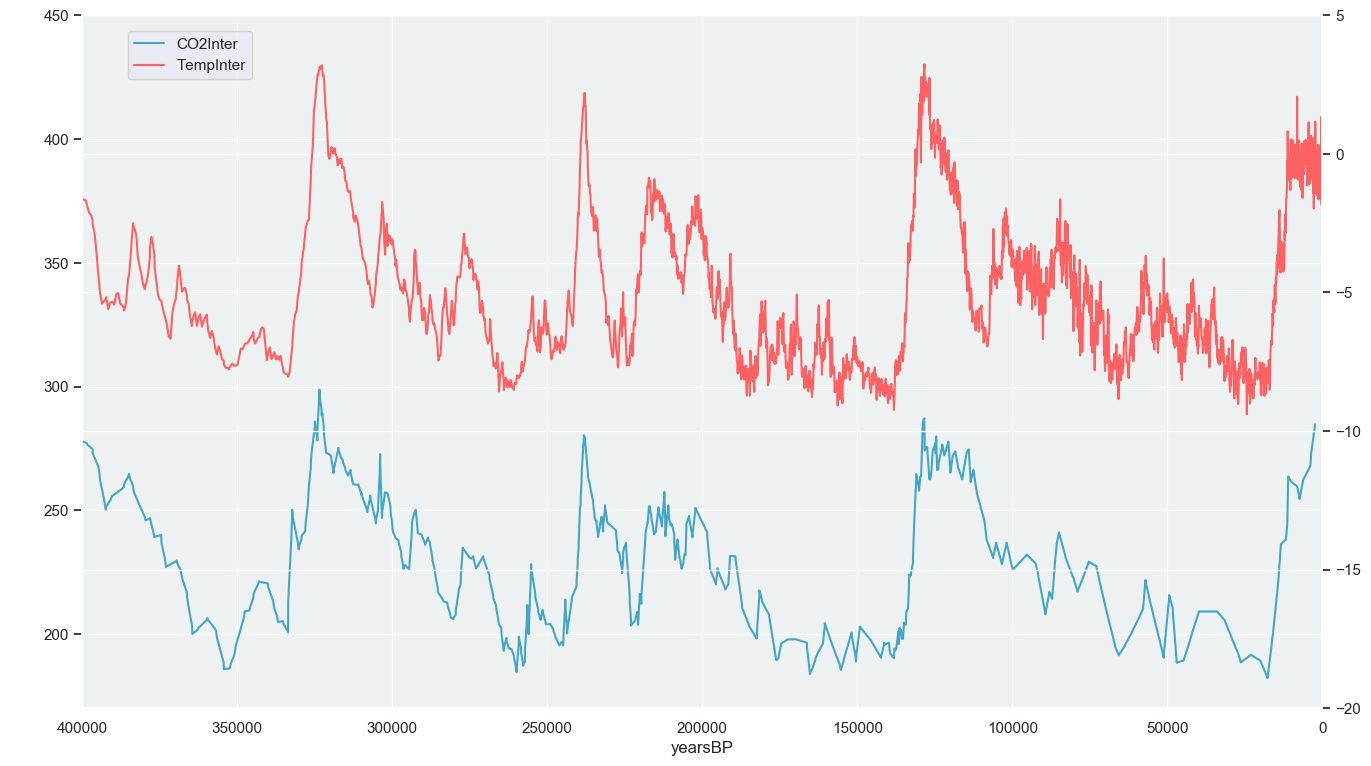

In [38]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))


ax1 = joinedVos.CO2Inter.plot(kind='line',color='#43A6C6')

ax2 = ax.twinx()
ax2 = joinedVos.TempInter.plot(kind='line',color='#FF6061',ax=ax2)

ax1.set_ylim(170,450)
ax2.set_ylim(-20,5)
ax.set_xlim(400000,0)
ax.set_facecolor('#EDF1F2')
ax.figure.legend(loc='upper left', bbox_to_anchor=(0.075, 0.825))

plt.show()


In [39]:
fullCO2Data.sort_values('Mean_age_of_air_yrBP')

,CO2Presentppm,CO2_conc_ppmv
Mean_age_of_air_yrBP,,
0,413.40,NaN
62,315.71,NaN
2342,284.70,284.7
3634,NaN,272.8
3833,NaN,268.1
...,...,...
409022,NaN,281.2
410831,NaN,276.3
414085,NaN,285.5


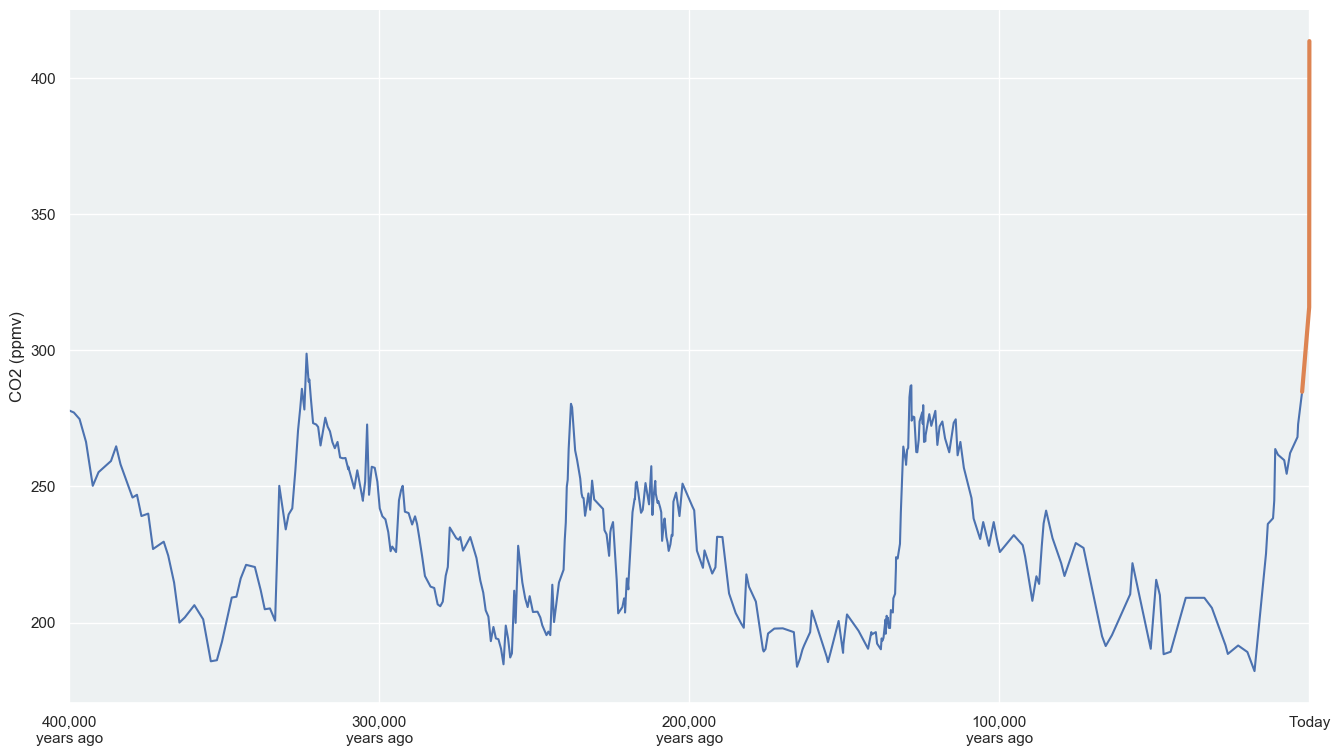

In [42]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
sns.despine()

fullCO2Data.CO2_conc_ppmv.plot(kind='line')
fullCO2Data.CO2Presentppm.plot(kind='line',linewidth=3,clip_on=False)

ax.set_xlim(400000,0)
plt.xticks(np.arange(0,500000,step=100000),('Today','100,000\nyears ago','200,000\nyears ago',
                                            '300,000\nyears ago','400,000\nyears ago'))
plt.ylabel('CO2 (ppmv)')
plt.xlabel('')
ax.set_facecolor('#EDF1F2')


# Emissions

In [103]:
emData

Year,Afghanistan,Africa,Albania,Algeria,Americas (other),Andorra,Angola,Anguilla,Antarctic Fisheries,Antigua and Barbuda,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Wallis and Futuna Islands,World,Yemen,Zambia,Zimbabwe
1751,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,9.350528e+06,0.0,0.0,0.0
1752,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,1.870472e+07,0.0,0.0,0.0
1753,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,2.805891e+07,0.0,0.0,0.0
1754,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,3.741677e+07,0.0,0.0,0.0
1755,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,4.677829e+07,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,133333663.0,3.789569e+10,252966224.0,3.513171e+09,8.894874e+10,11746784.0,483802609.0,2443888.0,153888.0,19540112.0,...,326159965.0,5.622211e+09,3642016.0,6.884396e+09,2.275257e+09,333424.0,1.430000e+12,538684418.0,169390168.0,658883535.0
2014,143122849.0,3.918617e+10,258678400.0,3.656348e+09,9.139192e+10,12208448.0,518260251.0,2586784.0,153888.0,20071392.0,...,332816072.0,5.726692e+09,3795904.0,7.068632e+09,2.434969e+09,355408.0,1.470000e+12,560946988.0,173645895.0,670749884.0
2015,153230277.0,4.047518e+10,264626124.0,3.806940e+09,9.382747e+10,12685687.0,553021380.0,2735961.0,153888.0,20626024.0,...,339467178.0,5.837362e+09,3963838.0,7.245529e+09,2.619471e+09,379399.0,1.500000e+12,581331585.0,178047308.0,681657488.0
2016,165488185.0,4.178583e+10,270898982.0,3.957319e+09,9.624253e+10,13197193.0,588372383.0,2888033.0,153888.0,21191421.0,...,346231602.0,5.935287e+09,4133697.0,7.411626e+09,2.817273e+09,403664.0,1.540000e+12,600467008.0,182622452.0,691590138.0


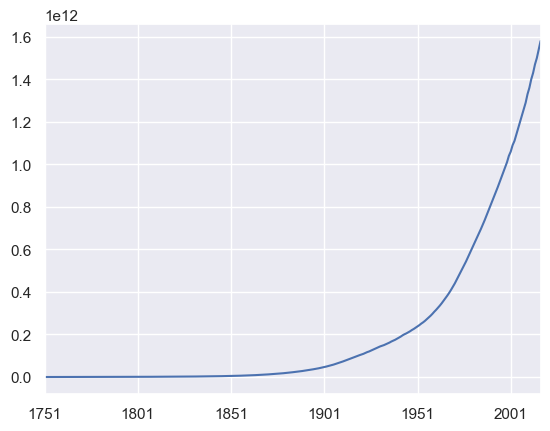

In [105]:
emData.World.plot(kind='line')